# Black-box maximisation with `BayesOptimization`

In this notebook we show how to use our codebase (notably the class `BayesOptimisation`) to apply Bayesian optimisation, using various techniques to tackle batch-acquisition function maximisation. To do so, we consider a toy black-box maximisation problem (`Ackley` function in $16$ dimensions), and run BO with different methods (ERM, FSM, compositional) to solve BO's inner problem.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, glob
#import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats, clear_output
set_matplotlib_formats('retina')
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12.0, 7.0)

from typing import *
from tqdm import tqdm
import torch
from torch import Tensor
import sys, os, shutil

ROOT_PROJECT =  os.path.join(os.path.normpath(os.path.join(os.getcwd(), "../"))) 
sys.path[0] = ROOT_PROJECT

In [2]:
from core.utils.utils_query import query_optimizer, query_test_func
from utils.utils_plot import plot_mean_std
from core.params_helper import ParamSpace
from core.bayes_opt import BayesOptimization

##### PyTorch setup

In [3]:
cuda = 1

tkwargs = {
        "dtype": torch.double,
        "device": torch.device(f"cuda:{cuda}" if torch.cuda.is_available() and cuda is not None else "cpu"),
    }
if torch.cuda.is_available() and cuda is not None:
    torch.cuda.set_device(tkwargs['device'])

##### Get toy black-box Ackley function in 16D

In [4]:
test_func = 'Ackley'
input_dim = 16
negate = True  # we maximise -f

testfunc = query_test_func(test_func, input_dim, negate).to(**tkwargs)
optimal_value = testfunc.optimal_value

bounds: Tensor = testfunc.bounds  # shape (2, d)

##### Specify search space through `ParamSpace` instance

In [5]:
# Hyper-rectangle search space
search_bounds = [
    {'name': f'x_{i}', 'type': 'continuous', 'domain': (bounds[0, i].item(), bounds[1, i].item())} for i in
    range(input_dim)
]

# List of transformations to apply to the search domain for BO search (could consider log-domain
# or any bijective transformation, but here there is no modification needed)
search_real_transfo = [
    {f'x_{i}': lambda w: w} for i in range(input_dim)
]

params_h = ParamSpace(search_bounds, search_real_transfo)

##### BO configuration

In [6]:
# Number of initial points
num_initial =  2 * input_dim

# See arguments Docstrings of `core.bayes_opt.BayesOptimization` class for further details on BO setup
bo_kwargs = dict(
    params_h=params_h,
    negate = False,
    noise_free = True,
    covar = 'matern-5/2',
    covar_kw = {},
    initial_design_numdata = num_initial,
    num_MC_samples_acq = 128,
    num_raw_samples = 500,
    num_starts = 32,
    num_opt_steps = 128,
    device=cuda
)

# Choose acquisition function
acq_func = 'qUpperConfidenceBound' 
acq_func_kwargs = {'beta': 2}

q = 16               # Number of points acquired at each acquisition step
num_acq_steps = 15  # Number of acquisition steps

n_trials = 5        # Number of repetition of the experiment

opt_regrets = {}    # Dictionary mapping optimiser to regrets

##### Generic function to run BO experiment 

In [7]:
def bo_exp(n_trials, **bo_kwargs):
    """ Run BO experiment with specified configuration for `n_trials` different seeds. 
        Return the induce immediate regrets.
    """
    regrets = []
    for seed in range(n_trials):
        print(f'BO with seed: {seed}')
        best_values: List[float] = []  # store best values observed after each acquisition step
        bo = BayesOptimization(**bo_kwargs, seed=seed)

        # initial random points:
        Xs: List[Dict[str, float]] = bo.gen(num_initial)
        # evaluate initial points
        X_to_eval: Tensor = torch.tensor(np.array([params_h.get_list_params_from_dict(X) for X in Xs])).to(**tkwargs)
        # Add them to the observed dataset of `bo` instance
        bo.observe(Xs, testfunc(X_to_eval))

        best_values.append(bo.data_Y.max().item())  # contains best value observed after initialisation

        for acq_step in range(num_acq_steps):
            # Generate points by maximising the acquisition function 
            Xs: List[Dict[str, float]] = bo.gen(q)
            
            # Evaluate suggested points
            X_to_eval: Tensor = torch.tensor(np.array([params_h.get_list_params_from_dict(X) for X in Xs]))
            new_values = testfunc(X_to_eval)
            
            # Observe the new input-output data
            bo.observe(Xs, new_values)
            
            best_values.append(max(best_values[-1], new_values.max().item()))

        regrets.append(optimal_value - np.array(best_values))
    return np.array(regrets)

#### Acquisition function maximisation techniques
BO's inner problem can be tackled with various optimisation techniques that can be easily specified by the user as shown below.

##### Optimise UCB via Random Search

In [8]:
optimizer_name = 'RandomSearch'

bo_extra_kw = dict(
    optimizer=optimizer_name,
    acq_func=acq_func,
    acq_func_kwargs=acq_func_kwargs
)

opt_regrets[optimizer_name] = bo_exp(n_trials, **bo_extra_kw, **bo_kwargs)

BO with seed: 0
BO with seed: 1
BO with seed: 2
BO with seed: 3
BO with seed: 4


##### Optimise UCB using `Adam` optimiser

In [9]:
optimizer_name = 'Adam'
bo_extra_kw = dict(
    optimizer=optimizer_name,
    optimizer_kwargs={'lr':0.12},
    acq_func=acq_func,
    acq_func_kwargs=acq_func_kwargs
)

opt_regrets[optimizer_name] = bo_exp(n_trials, **bo_extra_kw, **bo_kwargs)

BO with seed: 0
BO with seed: 1
BO with seed: 2
BO with seed: 3
BO with seed: 4


##### Optimise UCB in **Finite-Sum** form using `Adagrad` optimiser

In [10]:
optimizer_name = 'Adam'

bo_extra_kw = dict(
    optimizer = optimizer_name,
    optimizer_kwargs = {'lr':0.3},
    acq_func='qFiniteSum' + acq_func[1:],
    acq_func_kwargs=acq_func_kwargs,
    scheduler='ExponentialLR',  # can use a scheduler for the learning rate     
    scheduler_kwargs={'gamma':.68}
)

opt_regrets['FS-' + optimizer_name] = bo_exp(n_trials, **bo_extra_kw, **bo_kwargs)

BO with seed: 0
BO with seed: 1
BO with seed: 2
BO with seed: 3
BO with seed: 4


##### Optimise UCB in **compositional form** using `CAdam` optimiser (Memory-Efficient version)

In [11]:
optimizer_name = 'CAdam-ME'

bo_extra_kw = dict(
    optimizer = optimizer_name,
    optimizer_kwargs = {'lr':0.1,'beta':0.08,'mu':0.9,'C_gamma':0.5,'alpha_decay':0.5,'mu_decay':0.95,'gamma2_decay':0.8},
    acq_func = 'qCompositional' + acq_func[1:],
    acq_func_kwargs=acq_func_kwargs
#     verbose = 1
)

opt_regrets[optimizer_name] = bo_exp(n_trials, **bo_extra_kw, **bo_kwargs)

BO with seed: 0
Memory efficient setup
BO with seed: 1
Memory efficient setup
BO with seed: 2
Memory efficient setup
BO with seed: 3
Memory efficient setup
BO with seed: 4
Memory efficient setup


#### Visualise evolution of immediate log-regrets

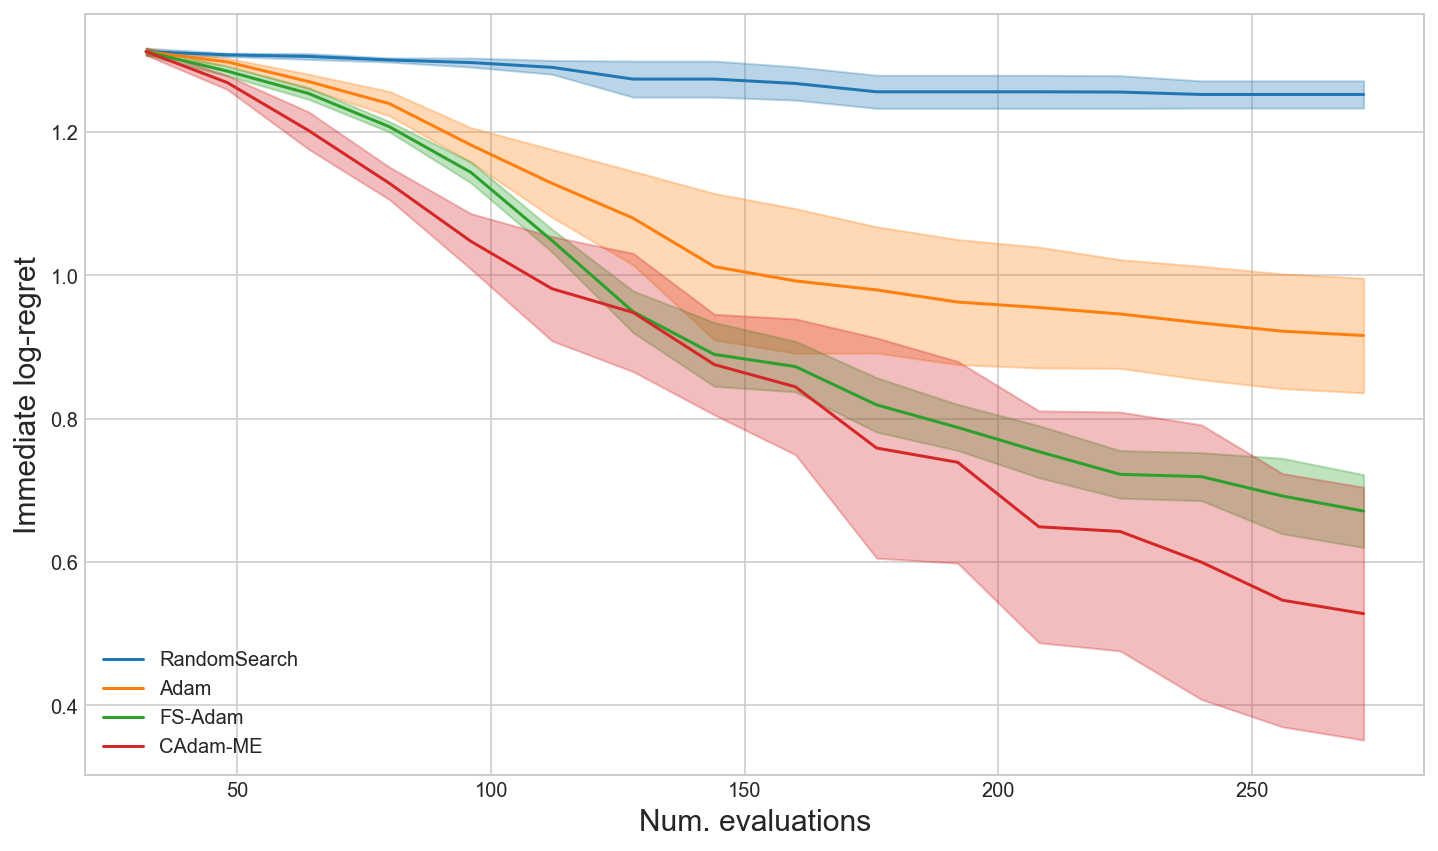

In [12]:
fig, ax = plt.subplots()

for opt_name, regret in opt_regrets.items():
    plot_mean_std(num_initial + np.arange(0, q * num_acq_steps + 1, q), np.log10(regret), label=opt_name, ax=ax)
plt.legend()
ax.set_xlabel('Num. evaluations', fontsize=15)
ax.set_ylabel('Immediate log-regret', fontsize=15)
plt.show()